In [159]:
#import ale_py
#import shimmy
import gymnasium as gym
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
#import os
import random
import copy
import time
import pickle
#import torcheck
import torchvision
import matplotlib.pyplot as plt

# NN

In [160]:

class CNN(nn.Module):

    def __init__(self):
        super().__init__()   
        
        self.stack = torch.nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        x = self.stack(x)
        return x


# Agent

In [161]:
class DQN_agent:

    def __init__(self):
        # Get cpu, gpu or mps device for training.
        self.device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )
        print(f"Using {self.device} device")
        self.pred_NN = CNN().to(self.device)
        self.target_NN = copy.deepcopy(self.pred_NN)
    
    def predict(self, x):
        pred = self.pred_NN.forward(x)
        return pred
    
    def action(self, pred):
        if random.random() < epsilon:
            action = random.randint(0, pred.size(dim=0) - 1)
        else: 
            action = torch.argmax(pred)
        return action
    
    def train(self, experiences):
      
        data_set = ExperiencesDataset(experiences, self)
        data_loader = DataLoader(data_set, batch_size=samples_per_batch, shuffle=True)
        optimizer = torch.optim.SGD(self.pred_NN.parameters(), lr=0.1)
        loss_fn = nn.MSELoss()
        epoch_loss = 0
        
        self.pred_NN.train()

        #torcheck.register(optimizer)
        #torcheck.add_module_changing_check(self.pred_NN, module_name="my_model")
        
        for batch, (state, y) in enumerate(data_loader):
            
            pred = self.pred_NN(state)
            loss = loss_fn(pred, y)
            
            loss.backward(retain_graph=True)
            #print('****** Gradients ******')
            #for p in self.pred_NN.parameters():
                #print(p.grad.norm())
            optimizer.step()
            epoch_loss += loss.item()
            optimizer.zero_grad()
            
            if batch == (len(data_loader) - 1):
                self.pred_NN.train(mode=False)
                return epoch_loss
        
    def copy(self):
        self.target_NN = copy.deepcopy(self.pred_NN)
        

# Dataset

In [162]:
class ExperiencesDataset(Dataset):
    
    def __init__(self, experiences, agent):
    
        self.states = []
        self.labels = []
        
        for n, experience in enumerate(experiences):
            #print('**************  CREATE LABEL  ********************\n')
            state, action, reward, next_state = experience
            
            #print('STATE\n')
            #img = state[0].permute(1, 2, 0).numpy()
            #plt.imshow(img)
            #plt.show()
            
            #print('NEXT STATE\n')
            #img = next_state[0].permute(1, 2, 0).numpy()
            #plt.imshow(img)
            #plt.show()

            #print('reward: ', reward, '\n')
            #print('action: ', action, '\n')
            
            pred = agent.predict(state)
            label = pred.detach().clone().squeeze()
            
            #print('pred: ', label, '\n')
            
            target_pred = agent.target_NN.forward(next_state)
            target_pred = target_pred.squeeze()
            target = reward + gamma * max(target_pred)
            
            
            label[action] = target
            #print('label: ', label, '\n')
            
            self.labels.append(label) 
            
            state = state.squeeze()
            self.states.append(state)
            #print('********************  END  ***********************\n')
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        return self.states[idx], self.labels[idx]

# Run agent (main)

Using cpu device
Plot filters in first layer



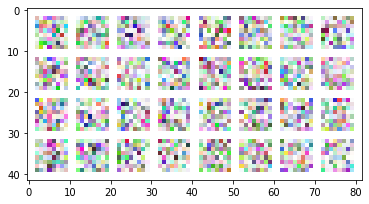

*********  Elapsed time: 0 seconds  *************

*********  Elapsed time: 449.74853801727295 seconds  *************



KeyboardInterrupt: 

In [166]:
#initialize environment
env = gym.make("ALE/Pacman-v5",render_mode="rgb_array")
#preprocess environment
env = gym.wrappers.AtariPreprocessing(env, screen_size=84, grayscale_obs=True, frame_skip=1, noop_max=30, scale_obs = True)
#start environment
state, info = env.reset()

#hyperparams
epsilon = 1
epsilon_decay = 0.9
gamma = 0.75
experience_capacity = 32000
training_freq = 1000
copying_freq = 4000
samples_per_training_session = 500
samples_per_batch = 50

#initialize agent
agent = DQN_agent()
agent.pred_NN.train(mode=False)
agent.target_NN.train(mode=False)

#load saved model to agent NNs
#agent.pred_NN.load_state_dict(torch.load("model"))
#agent.target_NN = copy.deepcopy(agent.pred_NN)

#select first action
action = random.randint(0, 4)

#get first states
state1, reward, terminated, truncated, info = env.step(action)
state2, reward, terminated, truncated, info = env.step(action)
state3, reward, terminated, truncated, info = env.step(action)
state4, reward, terminated, truncated, info = env.step(action)

#convert first states to correct datatype and stack
state1 = TF.to_tensor(state1)     
state2 = TF.to_tensor(state2)
state3 = TF.to_tensor(state3)
state4 = TF.to_tensor(state4)
state_stack = torch.cat((state1,state2,state3,state4))
state_stack = torch.unsqueeze(state_stack, 0)

#plot image, to se resolution
#img = state4.permute(1, 2, 0).numpy()
#plt.imshow(img)
#plt.show()

print('Plot filters in first layer\n')
kernels = agent.pred_NN.stack[0].weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
filter_img = torchvision.utils.make_grid(kernels, nrow = 8)
plt.imshow(filter_img.permute(1, 2, 0))
plt.show() 

#timer and variables connected to time
start_time = time.time()
epsilon_start_time = time.time()
elapsed_time = 0
max_time = 158000
training_time = 0
decay_freq = max_time/16

#for logging
training_session = 0

#loops until max_time is reached
while elapsed_time < max_time:
    experiences = []
    print(f'*********  Elapsed time: {elapsed_time} seconds  *************\n')
    #loops until experience_capacity is reached
    for i in range(1, experience_capacity):
        
    
        #predict q-values and choose action
        pred = agent.predict(state_stack)
        pred = pred.squeeze()
        action = agent.action(pred)
        
        #get next states
        next_state1, reward1, terminated, truncated, info = env.step(action)
        next_state2, reward2, terminated, truncated, info = env.step(action)
        next_state3, reward3, terminated, truncated, info = env.step(action)
        next_state4, reward4, terminated, truncated, info = env.step(action)

        #if pac-man dies 4 times, reset and start again
        if terminated or truncated: 
            #restart pacman
            env.reset()
            #select first action
            action = random.randint(0, 4)
            #get first states
            next_state1, reward1, terminated, truncated, info = env.step(action)
            next_state2, reward2, terminated, truncated, info = env.step(action)
            next_state3, reward3, terminated, truncated, info = env.step(action)
            next_state4, reward4, terminated, truncated, info = env.step(action)
            
        #convert next state to correct type and stack
        next_state1 = TF.to_tensor(next_state1)
        next_state2 = TF.to_tensor(next_state2)
        next_state3 = TF.to_tensor(next_state3)
        next_state4 = TF.to_tensor(next_state4)
        next_state_stack = torch.cat((next_state1,next_state2,next_state3,next_state4)) 
        next_state_stack = torch.unsqueeze(next_state_stack, 0)
        
        #sum rewards 
        tot_reward = 0
        tot_reward = reward1 + reward2 + reward3 + reward4
        
        #add to experiences
        save_this = [state_stack, action, tot_reward, next_state_stack] 
        experiences.append(save_this)
        
        #train
        if i % training_freq == 0:
            training_session += 1
            #print(f'-----Training {training_session}-----')
            elapsed_time = time.time() - start_time
            #print(f'Elapsed time: {elapsed_time} seconds')
            experiences_train = random.choices(experiences, k=samples_per_training_session)
            epoch_loss = agent.train(experiences_train)
            #print("Epoch loss: ", epoch_loss, "\n")  
            
        #copy
        if i % copying_freq == 0:
            #print('-----Copying pred_NN to target_NN-----\n')
            agent.copy()
            elapsed_time = time.time() - start_time
            if elapsed_time > max_time:
                break
                
        #next state stack becomes current state stack
        state_stack = next_state_stack
            
        
    #decay epsilon
    if(epsilon > 0.2 and (time.time() - epsilon_start_time) > decay_freq):
        print(f'------Epsilon decays after {(time.time() - epsilon_start_time)} seconds since last decay-----\n')
        print(f'old epsilon: {epsilon} \n')
        epsilon = epsilon * epsilon_decay 
        print(f'new epsilon: {epsilon}\n')
        epsilon_start_time = time.time()
        

print(f'*****stopped training after {elapsed_time} seconds*****\n')

print('*****Plot filters in first layer*****\n')
kernels = agent.pred_NN.stack[0].weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
filter_img = torchvision.utils.make_grid(kernels, nrow = 8)
plt.imshow(filter_img.permute(1, 2, 0))
plt.show() 

print('*****Pickle Dumping model*****\n')

file = open('safetyPickleDump', 'wb')
pickle.dump(agent, file)
file.close()

print("*****Saving model*****")
torch.save(agent.pred_NN.state_dict(), "model")

env.close()